In [17]:
! pip install striprtf

You should consider upgrading via the 'C:\Python39\python.exe -m pip install --upgrade pip' command.


In [35]:
# Import Libraries
import pandas as pd
import numpy as np
import json
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [36]:
# Load JSON Configuration and Dataset
from striprtf.striprtf import rtf_to_text

def load_json_from_rtf(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        rtf_content = file.read()
    plain_text = rtf_to_text(rtf_content)
    data = json.loads(plain_text)
    return data

config = load_json_from_rtf('algoparams_from_ui.json.rtf')
config = config['design_state_data']

# Load Dataset
data = pd.read_csv('iris.csv')
print("[INFO] Dataset Loaded Successfully.")
data.head()

[INFO] Dataset Loaded Successfully.


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [37]:
# Set target and features
target_col = config['target']['target']
prediction_type = config['target']['prediction_type']

feature_handling = config['feature_handling']
selected_features = [feat for feat, details in feature_handling.items() if details['is_selected']]

X = data[selected_features]
y = data[target_col]

In [38]:
# Apply missing value imputation
for feature, details in feature_handling.items():
    if details['is_selected']:
        feature_type = details['feature_variable_type']
        missing_info = details['feature_details']
        if feature_type == 'numerical' and missing_info['missing_values'] == 'Impute':
            strategy = missing_info['impute_with'].lower()
            if 'average' in strategy:
                imputer = SimpleImputer(strategy='mean')
                X[[feature]] = imputer.fit_transform(X[[feature]])
            else:
                fill_value = missing_info.get('impute_value', 0)
                X[feature].fillna(fill_value, inplace=True)
        elif feature_type == 'text':
            X[feature].fillna('missing', inplace=True) 

In [39]:
# Feature Generation
feature_gen = config.get('feature_generation', {})

# Linear interactions
if 'linear_interactions' in feature_gen:
    for f1, f2 in feature_gen['linear_interactions']:
        if f1 in X.columns and f2 in X.columns:
            if np.issubdtype(X[f1].dtype, np.number) and np.issubdtype(X[f2].dtype, np.number):
                X[f'{f1}plus{f2}'] = X[f1] + X[f2]

# Polynomial interactions
if 'polynomial_interactions' in feature_gen:
    for inter in feature_gen['polynomial_interactions']:
        f1, f2 = inter.split('/')
        if f1 in X.columns and f2 in X.columns:
            # Only create if both are numeric
            if np.issubdtype(X[f1].dtype, np.number) and np.issubdtype(X[f2].dtype, np.number):
                X[f'{f1}div{f2}'] = X[f1] / (X[f2].replace(0, np.nan))

# Explicit pairwise interactions
if 'explicit_pairwise_interactions' in feature_gen:
    for inter in feature_gen['explicit_pairwise_interactions']:
        f1, f2 = inter.split('/')
        if f1 in X.columns and f2 in X.columns:
            if np.issubdtype(X[f1].dtype, np.number) and np.issubdtype(X[f2].dtype, np.number):
                X[f'{f1}div{f2}'] = X[f1] / (X[f2].replace(0, np.nan))

In [40]:
# Encode non-numerical columns
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

In [41]:
# Feature Reduction
reduction_config = config['feature_reduction']

if reduction_config['feature_reduction_method'] == 'Tree-based':
    selector_model = RandomForestRegressor(n_estimators=int(reduction_config['num_of_trees']),
                                            max_depth=int(reduction_config['depth_of_trees']))
    selector = SelectFromModel(selector_model, max_features=int(reduction_config['num_of_features_to_keep']), threshold=-np.inf)
elif reduction_config['feature_reduction_method'] == 'Principal Component Analysis':
    pca = PCA(n_components=reduction_config['num_of_features_to_keep'])
    selector = pca
else:
    selector = 'passthrough' 

In [42]:
 # Model Selection
algorithm_config = config['algorithms']
selected_model = None

for model_key, model_details in algorithm_config.items():
    if model_details['is_selected']:
        if model_key == 'RandomForestRegressor':
            selected_model = RandomForestRegressor()
            model_params = {
                'model__n_estimators': [model_details['min_trees'], model_details['max_trees']],
                'model__max_depth': [model_details['min_depth'], model_details['max_depth']]
            }

if selected_model is None:
    raise ValueError("No model is selected in the JSON config!")

In [43]:
# Create final pipeline
pipeline = Pipeline([
    ('feature_reduction', selector),
    ('model', selected_model)
])

# Cross-validation
tscv = TimeSeriesSplit(n_splits=config['hyperparameters']['num_of_folds'])

# Grid Search
grid = GridSearchCV(estimator=pipeline,
                    param_grid=model_params,
                    cv=tscv,
                    n_jobs=-1,
                    verbose=1)

# Fitting
grid.fit(X, y)

print("[INFO] Best Hyperparameters:", grid.best_params_)

Fitting 6 folds for each of 4 candidates, totalling 24 fits
[INFO] Best Hyperparameters: {'model__max_depth': 20, 'model__n_estimators': 10}


In [44]:
# Predict and Evaluate
y_pred = grid.predict(X)

# Metrics
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

RMSE: 0.0100
MAE: 0.0040
R2 Score: 0.9998


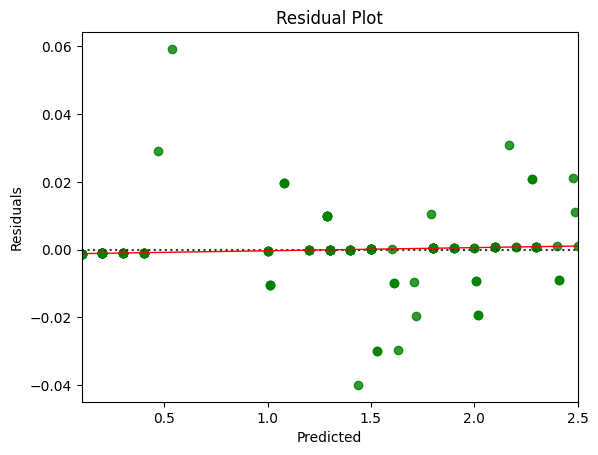

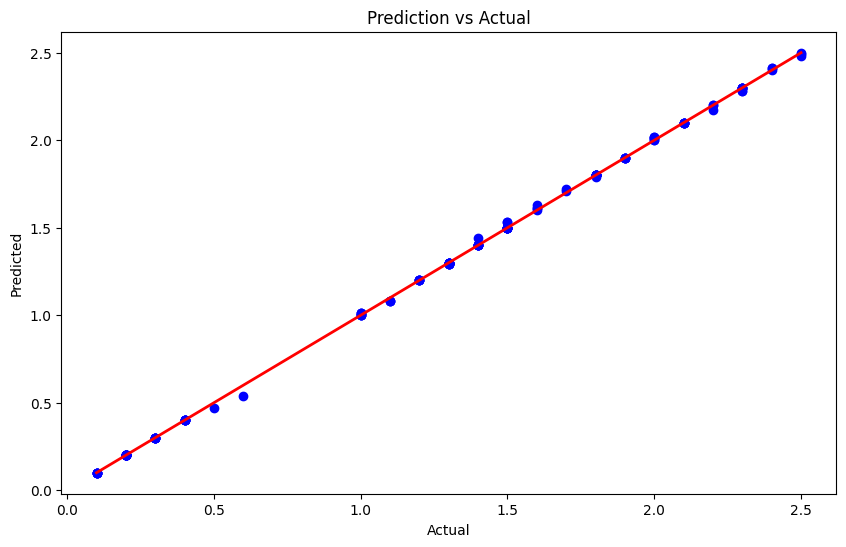

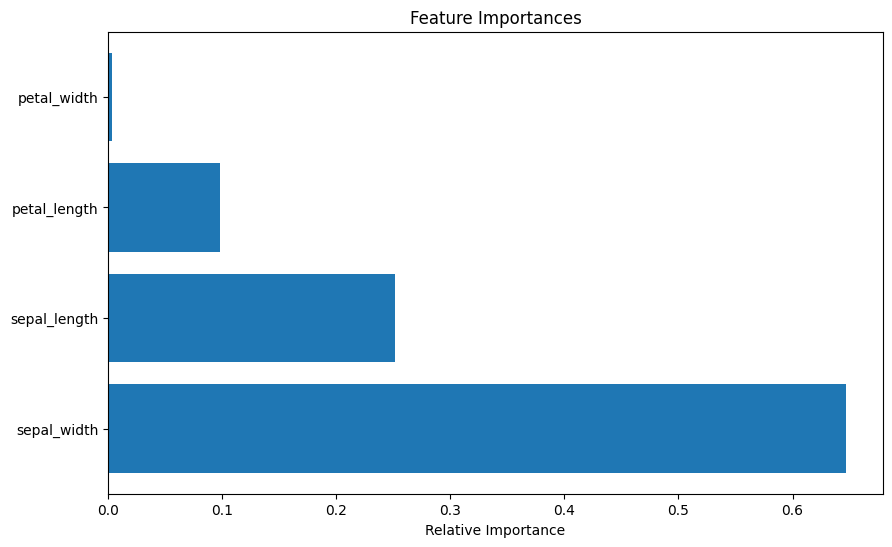

In [45]:
# Plots

# 1. Residual Plot
sns.residplot(x=y_pred, y=y - y_pred, lowess=True, color='g', line_kws={'color': 'red', 'lw': 1})
plt.title('Residual Plot')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()

# 2. Prediction vs Actual Plot
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='b')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='r', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Prediction vs Actual')
plt.show()

# 3. Feature Importance
if isinstance(selector, SelectFromModel):
    model = grid.best_estimator_.named_steps['model']
    importances = model.feature_importances_

    # After feature selection, reduce the importances to match the number of selected features
    if isinstance(selector, PCA):
        importances = importances[:X.shape[1]]

    # Sort the features by importance
    indices = np.argsort(importances)[::-1]
    
    # Ensure the plot aligns with the selected features
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()